In [1]:
# This Python script will load binary data files from the mmWave radar,
# perform spectral analysis, and identify Periodic Micro Motions (PMM) features.

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal.windows import hamming

In [2]:
def load_binary_data(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.int16)
    return data

# Process data in smaller chunks to avoid memory issues
files = ['data/drone_steady_0/master_0000_data.bin', 
         'data/drone_steady_0/slave1_0000_data.bin', 
         'data/drone_steady_0/slave2_0000_data.bin', 
         'data/drone_steady_0/slave3_0000_data.bin']

In [3]:
chunk_size = int(1e5)  # Number of samples to process at a time

# Parameters
adc_samples = 256  # Number of samples per chirp
nchirp_loops = 64  # Number of chirps per frame
sample_freq = 8e6  # Sampling frequency in Hz

In [4]:
master_file = files[0]
slave_files = files[1:]

# Radar parameters (adjust based on your radar configuration)
num_rx_master = 4  # Number of RX antennas in the master
num_rx_slaves = 4  # Assuming each slave also has 4 antennas
num_chirps = 128   # Number of chirps per frame
num_samples_per_chirp = 256  # Number of samples per chirp
total_num_rx = num_rx_master + len(slave_files) * num_rx_slaves  # Total RX antennas


In [5]:
# Function to load binary data from file
def load_bin_file(file_path, num_rx, num_samples_per_chirp, num_chirps):
    adc_data = np.fromfile(file_path, dtype=np.int16)
    # Reshape to (number of chirps * number of RX * 2) to get I/Q data
    adc_data = adc_data.reshape((-1, num_rx * 2))
    
    # Separate I/Q data
    adc_I = adc_data[:, 0::2]  # Even indices for I data
    adc_Q = adc_data[:, 1::2]  # Odd indices for Q data
    
    # Combine I and Q to form complex signal
    adc_complex = np.array(adc_I + 1j * adc_Q, dtype=np.complex64)
    return adc_complex

# Load data from master and slave files
master_data = load_bin_file(master_file, num_rx_master, num_samples_per_chirp, num_chirps)

slave_data_list = []
for slave_file in slave_files:
    slave_data = load_bin_file(slave_file, num_rx_slaves, num_samples_per_chirp, num_chirps)
    slave_data_list.append(slave_data)

# Combine master and slave data (assuming they capture data for the same chirps)
# The result will be of shape (num_samples_per_chirp, total_num_rx, num_chirps)
combined_data = np.concatenate([master_data] + slave_data_list, axis=1)


In [6]:
# Perform range FFT (1D FFT along the samples' direction)
range_profile = np.fft.fft(combined_data, n=num_samples_per_chirp, axis=0)

# Perform Doppler FFT (2D FFT along the chirp direction)
doppler_map = np.fft.fftshift(np.fft.fft(range_profile, n=num_chirps, axis=1), axes=1)

# Plot Range-Doppler map for the first antenna
import matplotlib.pyplot as plt
plt.imshow(np.abs(doppler_map[:, :, 0]), cmap='jet', aspect='auto')
plt.title('Range-Doppler Map (Antenna 1)')
plt.xlabel('Doppler Bin')
plt.ylabel('Range Bin')
plt.colorbar(label='Amplitude')
plt.show()


MemoryError: Unable to allocate 7.88 GiB for an array with shape (33030144, 16) and data type complex128

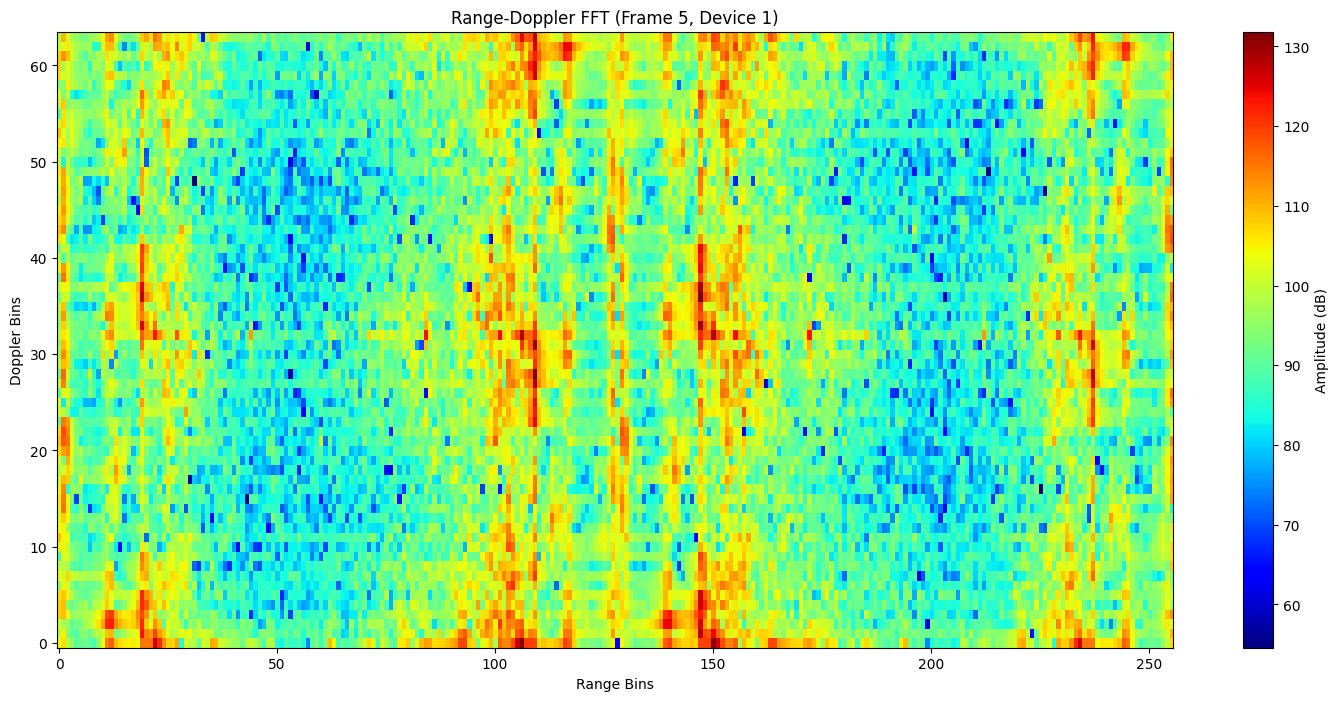

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift



# Parameters
adc_samples = 256  # Number of samples per chirp
nchirp_loops = 64  # Number of chirps per frame
sample_freq = 8e6  # Sampling frequency (Hz)
frame_size = adc_samples * nchirp_loops  # Total samples per frame per antenna : 16,384



# Function to load raw ADC data for a specific frame and device
def load_adc_data(file_path, frame_number, adc_samples, nchirp_loops):
    # Calculate the byte offset to seek to the correct frame
    offset = frame_number * adc_samples * nchirp_loops * 2  # Each sample is 2 bytes (16-bit)
    
    # Open the binary file and read the data for the specified frame
    with open(file_path, 'rb') as f:
        f.seek(offset)
        # Read the data for the current frame
        raw_data = np.fromfile(f, dtype=np.int16, count=adc_samples * nchirp_loops)
        
    # Reshape the data to form (nchirp_loops x adc_samples) for Range-Doppler processing
    frame_data = raw_data.reshape((nchirp_loops, adc_samples))
    return frame_data



# Function to perform Range-Doppler FFT
def range_doppler_fft(frame_data, adc_samples, nchirp_loops, sample_freq):
    # Range FFT (Along ADC samples axis)
    range_fft = fft(frame_data, axis=1)
    
    # Doppler FFT (Along chirps axis)
    doppler_fft = fft(range_fft, axis=0)
    
    # Apply fftshift to center the Doppler FFT output
    doppler_fft_shifted = fftshift(doppler_fft, axes=0)
    
    # Return Range-Doppler FFT result
    return doppler_fft_shifted



# Function to plot Range-Doppler heatmap
def plot_range_doppler(doppler_data, frame_number, device_number):
    plt.figure(figsize=(18, 8))
    plt.imshow(20 * np.log10(np.abs(doppler_data)), aspect='auto', cmap='jet', origin='lower')
    plt.colorbar(label='Amplitude (dB)')
    plt.title(f'Range-Doppler FFT (Frame {frame_number}, Device {device_number})')
    plt.xlabel('Range Bins')
    plt.ylabel('Doppler Bins')
    plt.show()



# Main function to process a specific frame and device
def process_frame_and_device(frame_number, device_number):
    # Define file path based on the device number (you will need to adjust the paths accordingly)
    if device_number == 1:
        file_path = "data/drone_steady_0/master_0000_data.bin"
    elif device_number == 2:
        file_path = "data/drone_steady_0/slave1_0000_data.bin"
    elif device_number == 3:
        file_path = "data/drone_steady_0/slave2_0000_data.bin"
    elif device_number == 4:
        file_path = "data/drone_steady_0/slave3_0000_data.bin"
    else:
        raise ValueError("Invalid device number! Must be 1 (master) or 2-4 (slaves).")
    
    # Load ADC data for the specific frame and device
    frame_data = load_adc_data(file_path, frame_number, adc_samples, nchirp_loops)
    
    # Perform Range-Doppler FFT
    doppler_data = range_doppler_fft(frame_data, adc_samples, nchirp_loops, sample_freq)
    
    # Plot the Range-Doppler FFT result
    plot_range_doppler(doppler_data, frame_number, device_number)



# Example: Process frame 5 for device 2 (slave 1)
process_frame_and_device(frame_number=5, device_number=1)

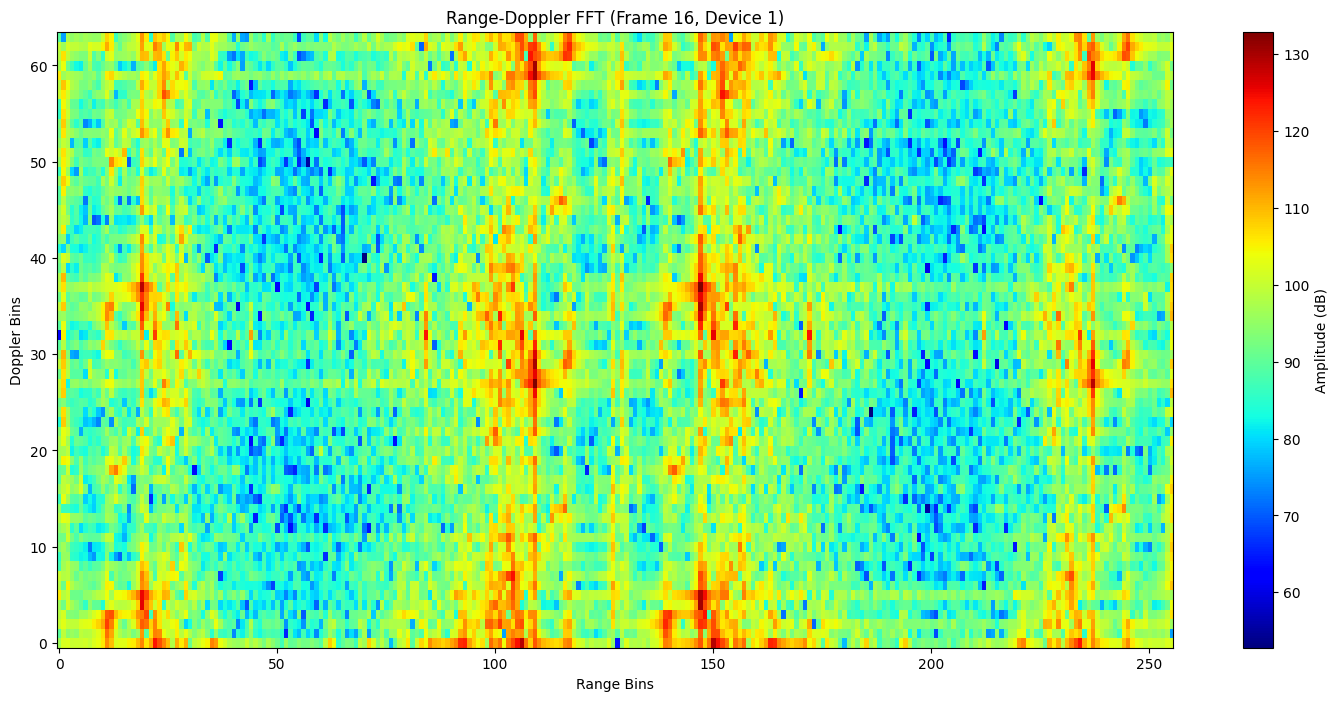

In [4]:
# Example: Process frame 5 for device 2 (slave 1)
process_frame_and_device(frame_number=16, device_number=1)

In [15]:
from math import floor

J = [*range(2, 21)] # folding values
I = [*range(1, 21)] # range bins
D = []

for j in J:
    for k in I:
        for m in range(1, 20 // j + 1):
            print(f"j={j}, k={k}, m={m}")
            

j=2, k=1, m=1
j=2, k=1, m=2
j=2, k=1, m=3
j=2, k=1, m=4
j=2, k=1, m=5
j=2, k=1, m=6
j=2, k=1, m=7
j=2, k=1, m=8
j=2, k=1, m=9
j=2, k=1, m=10
j=2, k=2, m=1
j=2, k=2, m=2
j=2, k=2, m=3
j=2, k=2, m=4
j=2, k=2, m=5
j=2, k=2, m=6
j=2, k=2, m=7
j=2, k=2, m=8
j=2, k=2, m=9
j=2, k=2, m=10
j=2, k=3, m=1
j=2, k=3, m=2
j=2, k=3, m=3
j=2, k=3, m=4
j=2, k=3, m=5
j=2, k=3, m=6
j=2, k=3, m=7
j=2, k=3, m=8
j=2, k=3, m=9
j=2, k=3, m=10
j=2, k=4, m=1
j=2, k=4, m=2
j=2, k=4, m=3
j=2, k=4, m=4
j=2, k=4, m=5
j=2, k=4, m=6
j=2, k=4, m=7
j=2, k=4, m=8
j=2, k=4, m=9
j=2, k=4, m=10
j=2, k=5, m=1
j=2, k=5, m=2
j=2, k=5, m=3
j=2, k=5, m=4
j=2, k=5, m=5
j=2, k=5, m=6
j=2, k=5, m=7
j=2, k=5, m=8
j=2, k=5, m=9
j=2, k=5, m=10
j=2, k=6, m=1
j=2, k=6, m=2
j=2, k=6, m=3
j=2, k=6, m=4
j=2, k=6, m=5
j=2, k=6, m=6
j=2, k=6, m=7
j=2, k=6, m=8
j=2, k=6, m=9
j=2, k=6, m=10
j=2, k=7, m=1
j=2, k=7, m=2
j=2, k=7, m=3
j=2, k=7, m=4
j=2, k=7, m=5
j=2, k=7, m=6
j=2, k=7, m=7
j=2, k=7, m=8
j=2, k=7, m=9
j=2, k=7, m=10
j=2, k=8, m=1

In [3]:
# Function to perform Range-Doppler FFT
def range_fft(frame_data, adc_samples, nchirp_loops, sample_freq):
    # Range FFT (Along ADC samples axis)
    range_fft = fft(frame_data, axis=1)
    
    # # Doppler FFT (Along chirps axis)
    # doppler_fft = fft(range_fft, axis=0)
    
    # Apply fftshift to center the Doppler FFT output
    doppler_fft_shifted = fftshift(range_fft, axes=0)
    
    # Return Range-Doppler FFT result
    return doppler_fft_shifted

In [4]:
# Main function to process a specific frame and device
def process_frame_and_device2(frame_number, device_number):
    # Define file path based on the device number (you will need to adjust the paths accordingly)
    if device_number == 1:
        file_path = "data/drone_steady_0/master_0000_data.bin"
    elif device_number == 2:
        file_path = "data/drone_steady_0/slave1_0000_data.bin"
    elif device_number == 3:
        file_path = "data/drone_steady_0/slave2_0000_data.bin"
    elif device_number == 4:
        file_path = "data/drone_steady_0/slave3_0000_data.bin"
    else:
        raise ValueError("Invalid device number! Must be 1 (master) or 2-4 (slaves).")
    
    # Load ADC data for the specific frame and device
    frame_data = load_adc_data(file_path, frame_number, adc_samples, nchirp_loops)
    
    # Perform Range-Doppler FFT
    doppler_data = range_fft(frame_data, adc_samples, nchirp_loops, sample_freq)
    
    # Plot the Range-Doppler FFT result
    plot_range_doppler(doppler_data, frame_number, device_number)

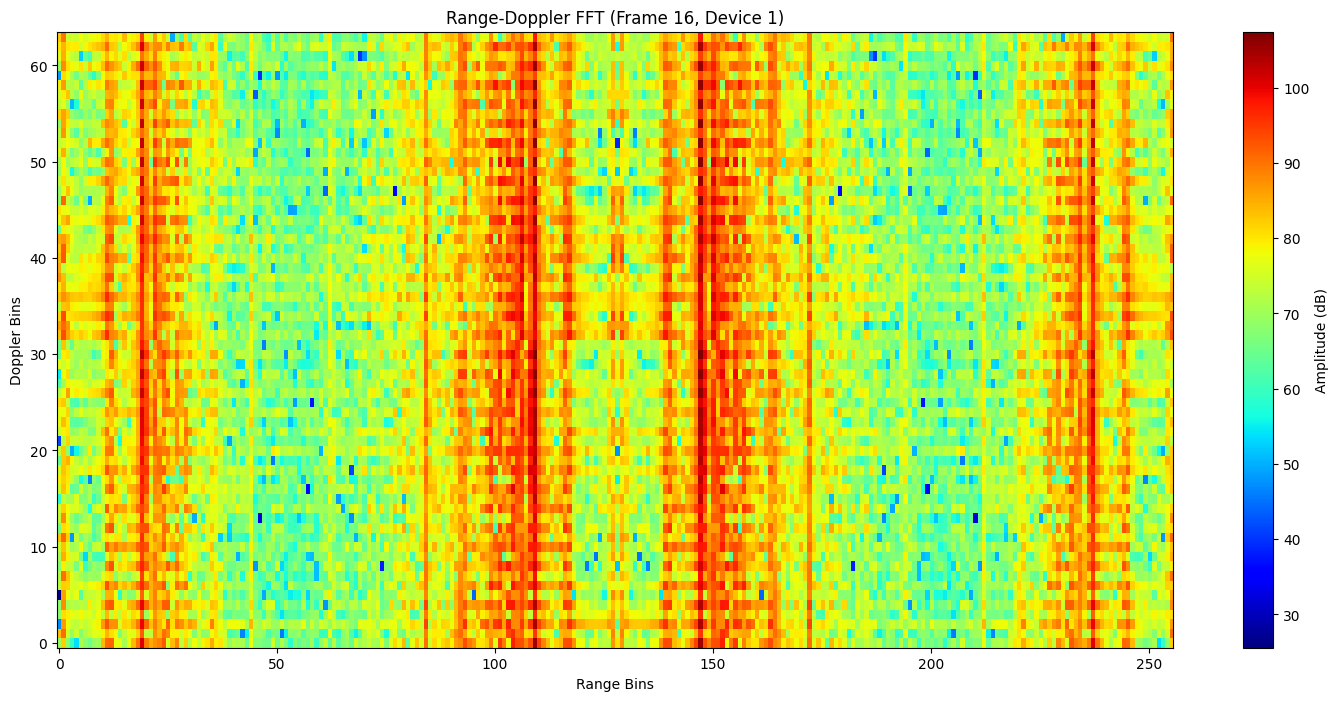

In [5]:
# Example: Process frame 5 for device 2 (slave 1)
process_frame_and_device2(frame_number=16, device_number=1)